In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102744 sha256=c9991cc28bf3ba73e20d2c86104218619a975ee0c7070970c2cde30d15cc6c45
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [4]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
cwd = os.getcwd()


train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [7]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


In [ ]:
X_train_df

In [8]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)


(753, 96, 144, 1) (86, 96, 144, 1)


In [9]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 32  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernal_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 200

In [10]:
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96,144,1)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48,72,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (12,18,32)
x = Flatten()(x) # shape: (6912,1)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,1)


z_mean    = Dense(latent_dim, name="z_mean")(x) # shape: (2,1)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,1)


def sample_latent_features(distribution):
    """
    This function takes previously calculated mean & variance,
    and returns back a latent encoding vector.
    """

    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random


z         = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 32)   544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 32)   16416       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 32)   16416       ['conv2d_1[0][0]']         

In [11]:
decoder_input = Input(shape=(latent_dim,)) # shape: (2,1)
cond_input    = Input(shape=(X_train.shape[1],)) # shape: (2,1)
x = keras.layers.Concatenate(axis=1)([decoder_input]) # shape: (4,1)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,1)
x = Reshape((12, 18, n_filters))(x) # shape: (12,18,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (48,72,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (96,144,32)
decoder_output = Conv2DTranspose(1, kernal_size, activation="linear", padding="same")(x) # shape: (96,144,1)
decoder_model = Model([decoder_input,cond_input], decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 6912)         20736       ['concatenate[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 12, 18, 32)   0           ['dense_1[0][0]']                
                                                                                            

In [12]:
encoded = encoder_model(encoder_inputs)
decoded = decoder_model([encoded,cond_input])
autoencoder = Model([encoder_inputs,cond_input], decoded)

In [13]:
def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*96*144

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [14]:
autoencoder.compile(loss=get_loss(z_mean,z_log_var),
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))# add legacy acc to new update
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder (Functional)           (None, 2)            254724      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 decoder (Functional)           (None, 96, 144, 1)   70497       ['encoder[0][0]',            

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = autoencoder.fit([y_train,X_train], y_train,
                          epochs=num_epochs,
                          batch_size=minibatch_size,
                          validation_split=0.2)

Train on 602 samples, validate on 151 samples
Epoch 1/200
602/602 [==============================] - ETA: 0s - loss: 14903.3140

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


602/602 [==============================] - 15s 24ms/sample - loss: 14903.3140 - val_loss: 9897.6933
Epoch 2/200
602/602 [==============================] - 0s 683us/sample - loss: 12892.2087 - val_loss: 10686.4074
Epoch 3/200
602/602 [==============================] - 0s 693us/sample - loss: 9779.4313 - val_loss: 11375.3275
Epoch 4/200
602/602 [==============================] - 0s 705us/sample - loss: 5474.5093 - val_loss: 8585.3835
Epoch 5/200
602/602 [==============================] - 0s 711us/sample - loss: 4128.8958 - val_loss: 8422.8494
Epoch 6/200
602/602 [==============================] - 0s 699us/sample - loss: 3683.6019 - val_loss: 8259.5714
Epoch 7/200
602/602 [==============================] - 0s 721us/sample - loss: 3393.0187 - val_loss: 8084.3363
Epoch 8/200
602/602 [==============================] - 0s 737us/sample - loss: 3241.2419 - val_loss: 7906.4313
Epoch 9/200
602/602 [==============================] - 0s 744us/sample - loss: 3129.6538 - val_loss: 7737.4329
Epoch 10/

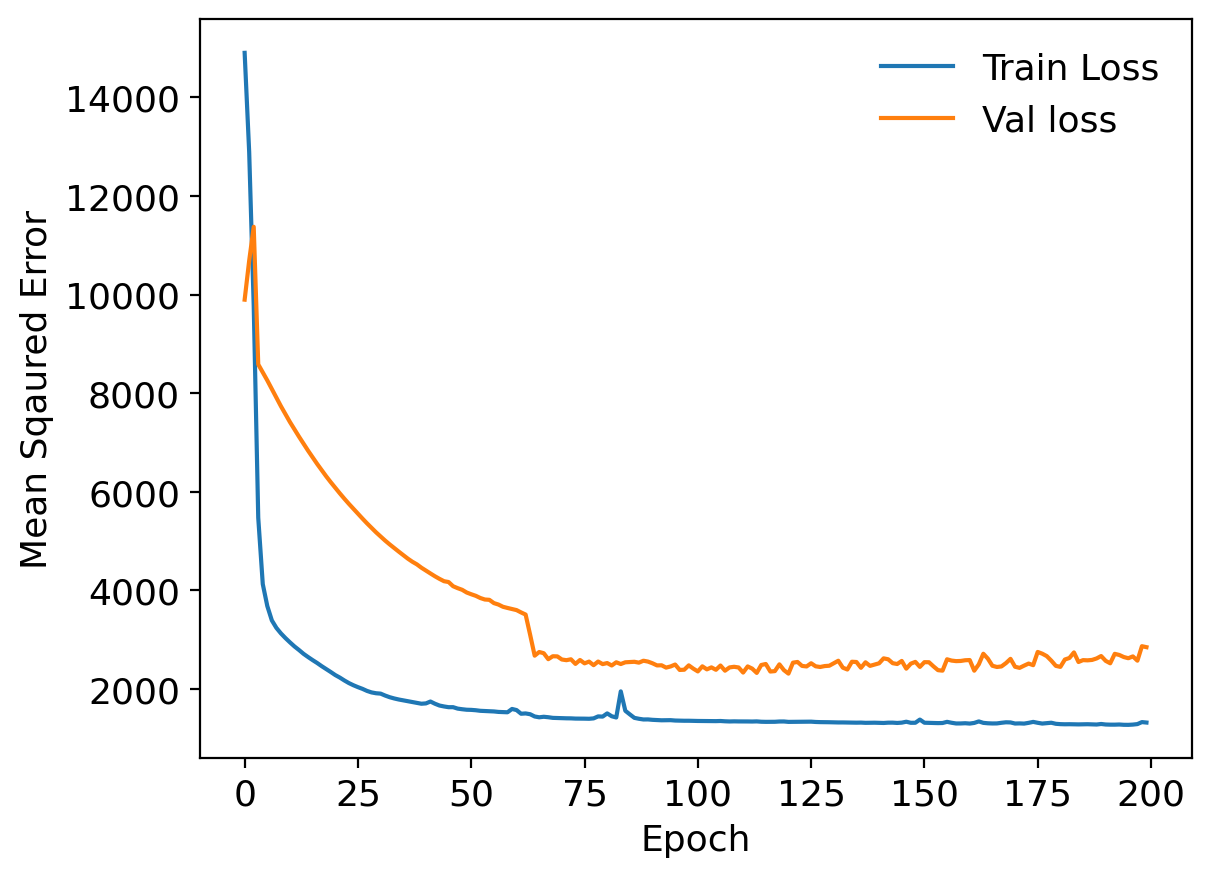

In [16]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqaured Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()


plot_history(history)

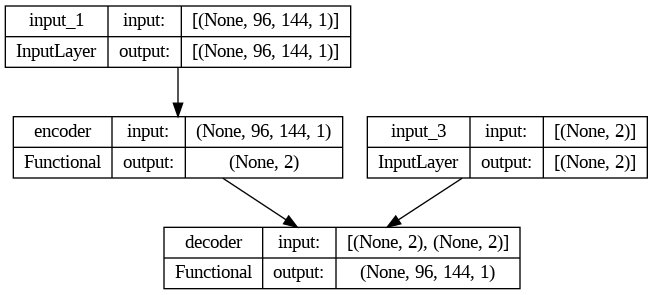

In [ ]:
tf.keras.utils.plot_model(autoencoder, to_file='model_summary.png', show_shapes=True)

In [17]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])

y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values,
                               'latitude': y_test_xr.latitude.values,
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
a = y_test_pre.to_dataframe()
b = y_test_xr['tas'].to_dataframe()

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have reconstructed output from VAE stored in a variable 'reconstructed_data'
reconstructed_data = a.to_numpy()

# Assuming you have the original input data stored in a variable 'original_data'
original_data = b.to_numpy()

# Flatten the data for calculating RMSE
reconstructed_data_flat = reconstructed_data.flatten()
original_data_flat = original_data.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_data_flat, reconstructed_data_flat))

print("RMSE:", rmse)

RMSE: 0.3839896


In [ ]:
# predict
standard_posterior_mean, standard_posterior_var = history.predict(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

In [ ]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)

In [28]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(b.tas[35], a.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(b.tas[85], a.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(b.tas[30:41], a.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(b.tas[75:], a.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(br.tas[35:], a.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

KeyError: ignored

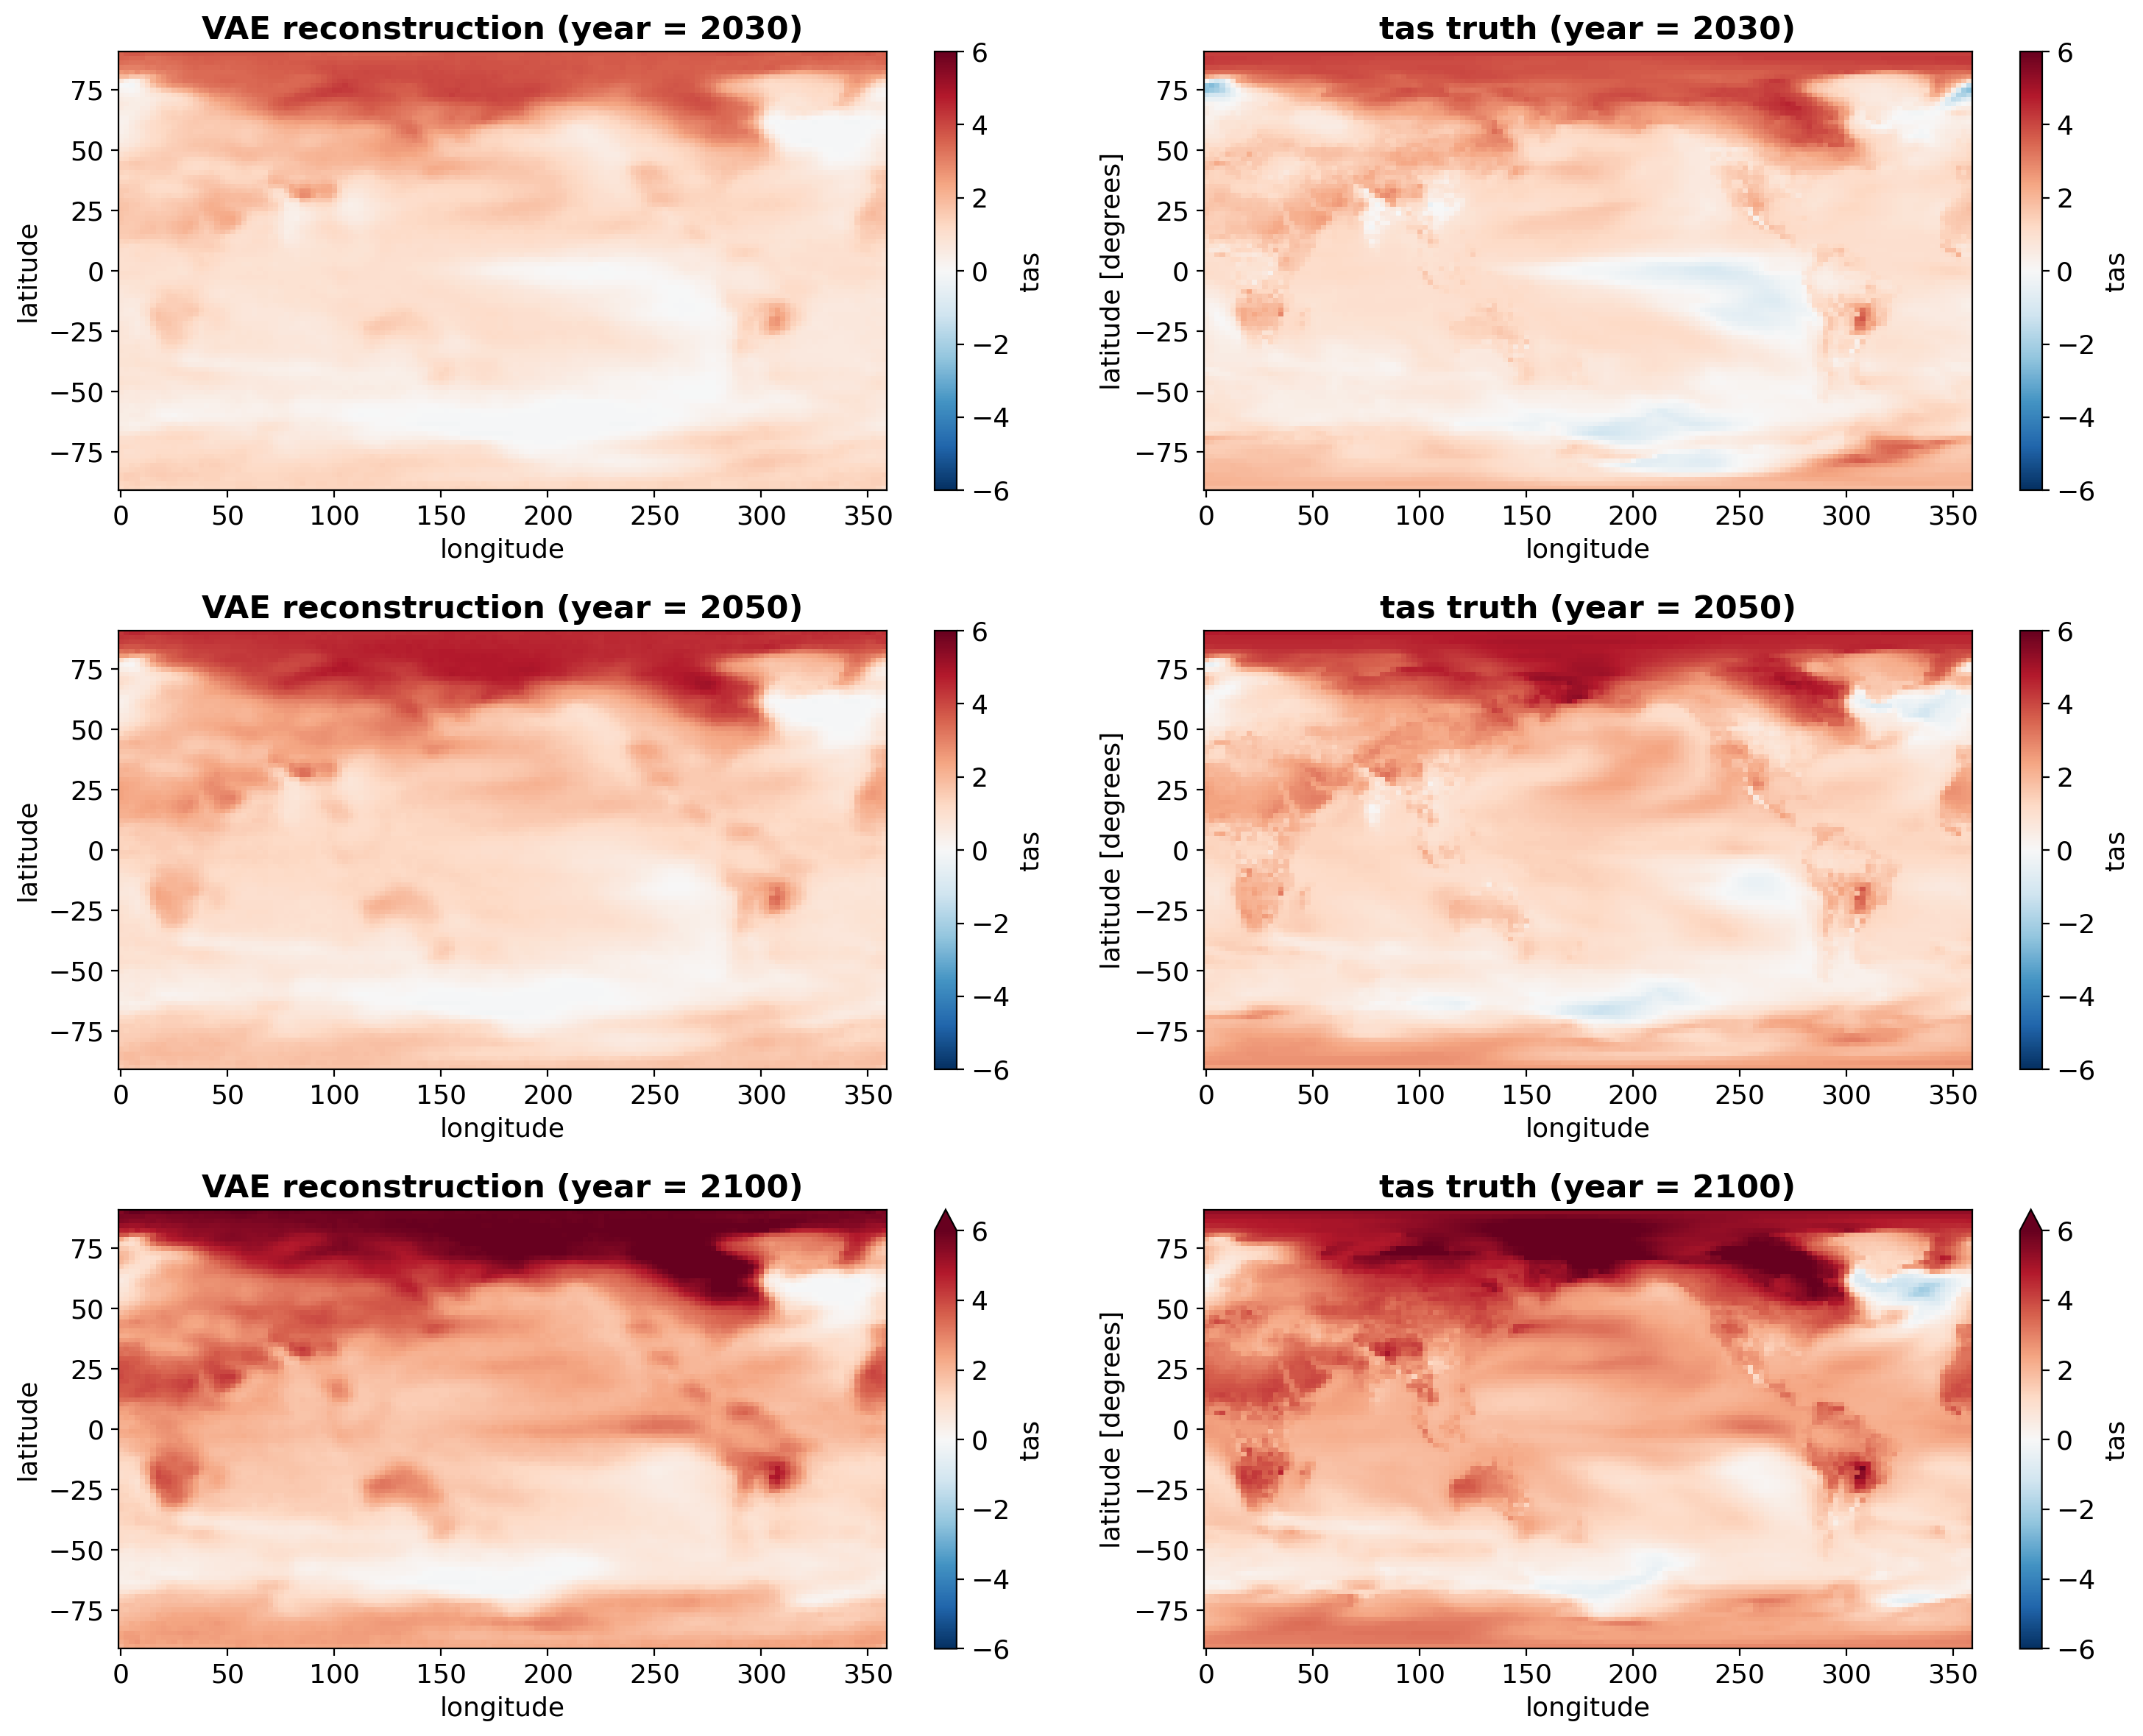

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

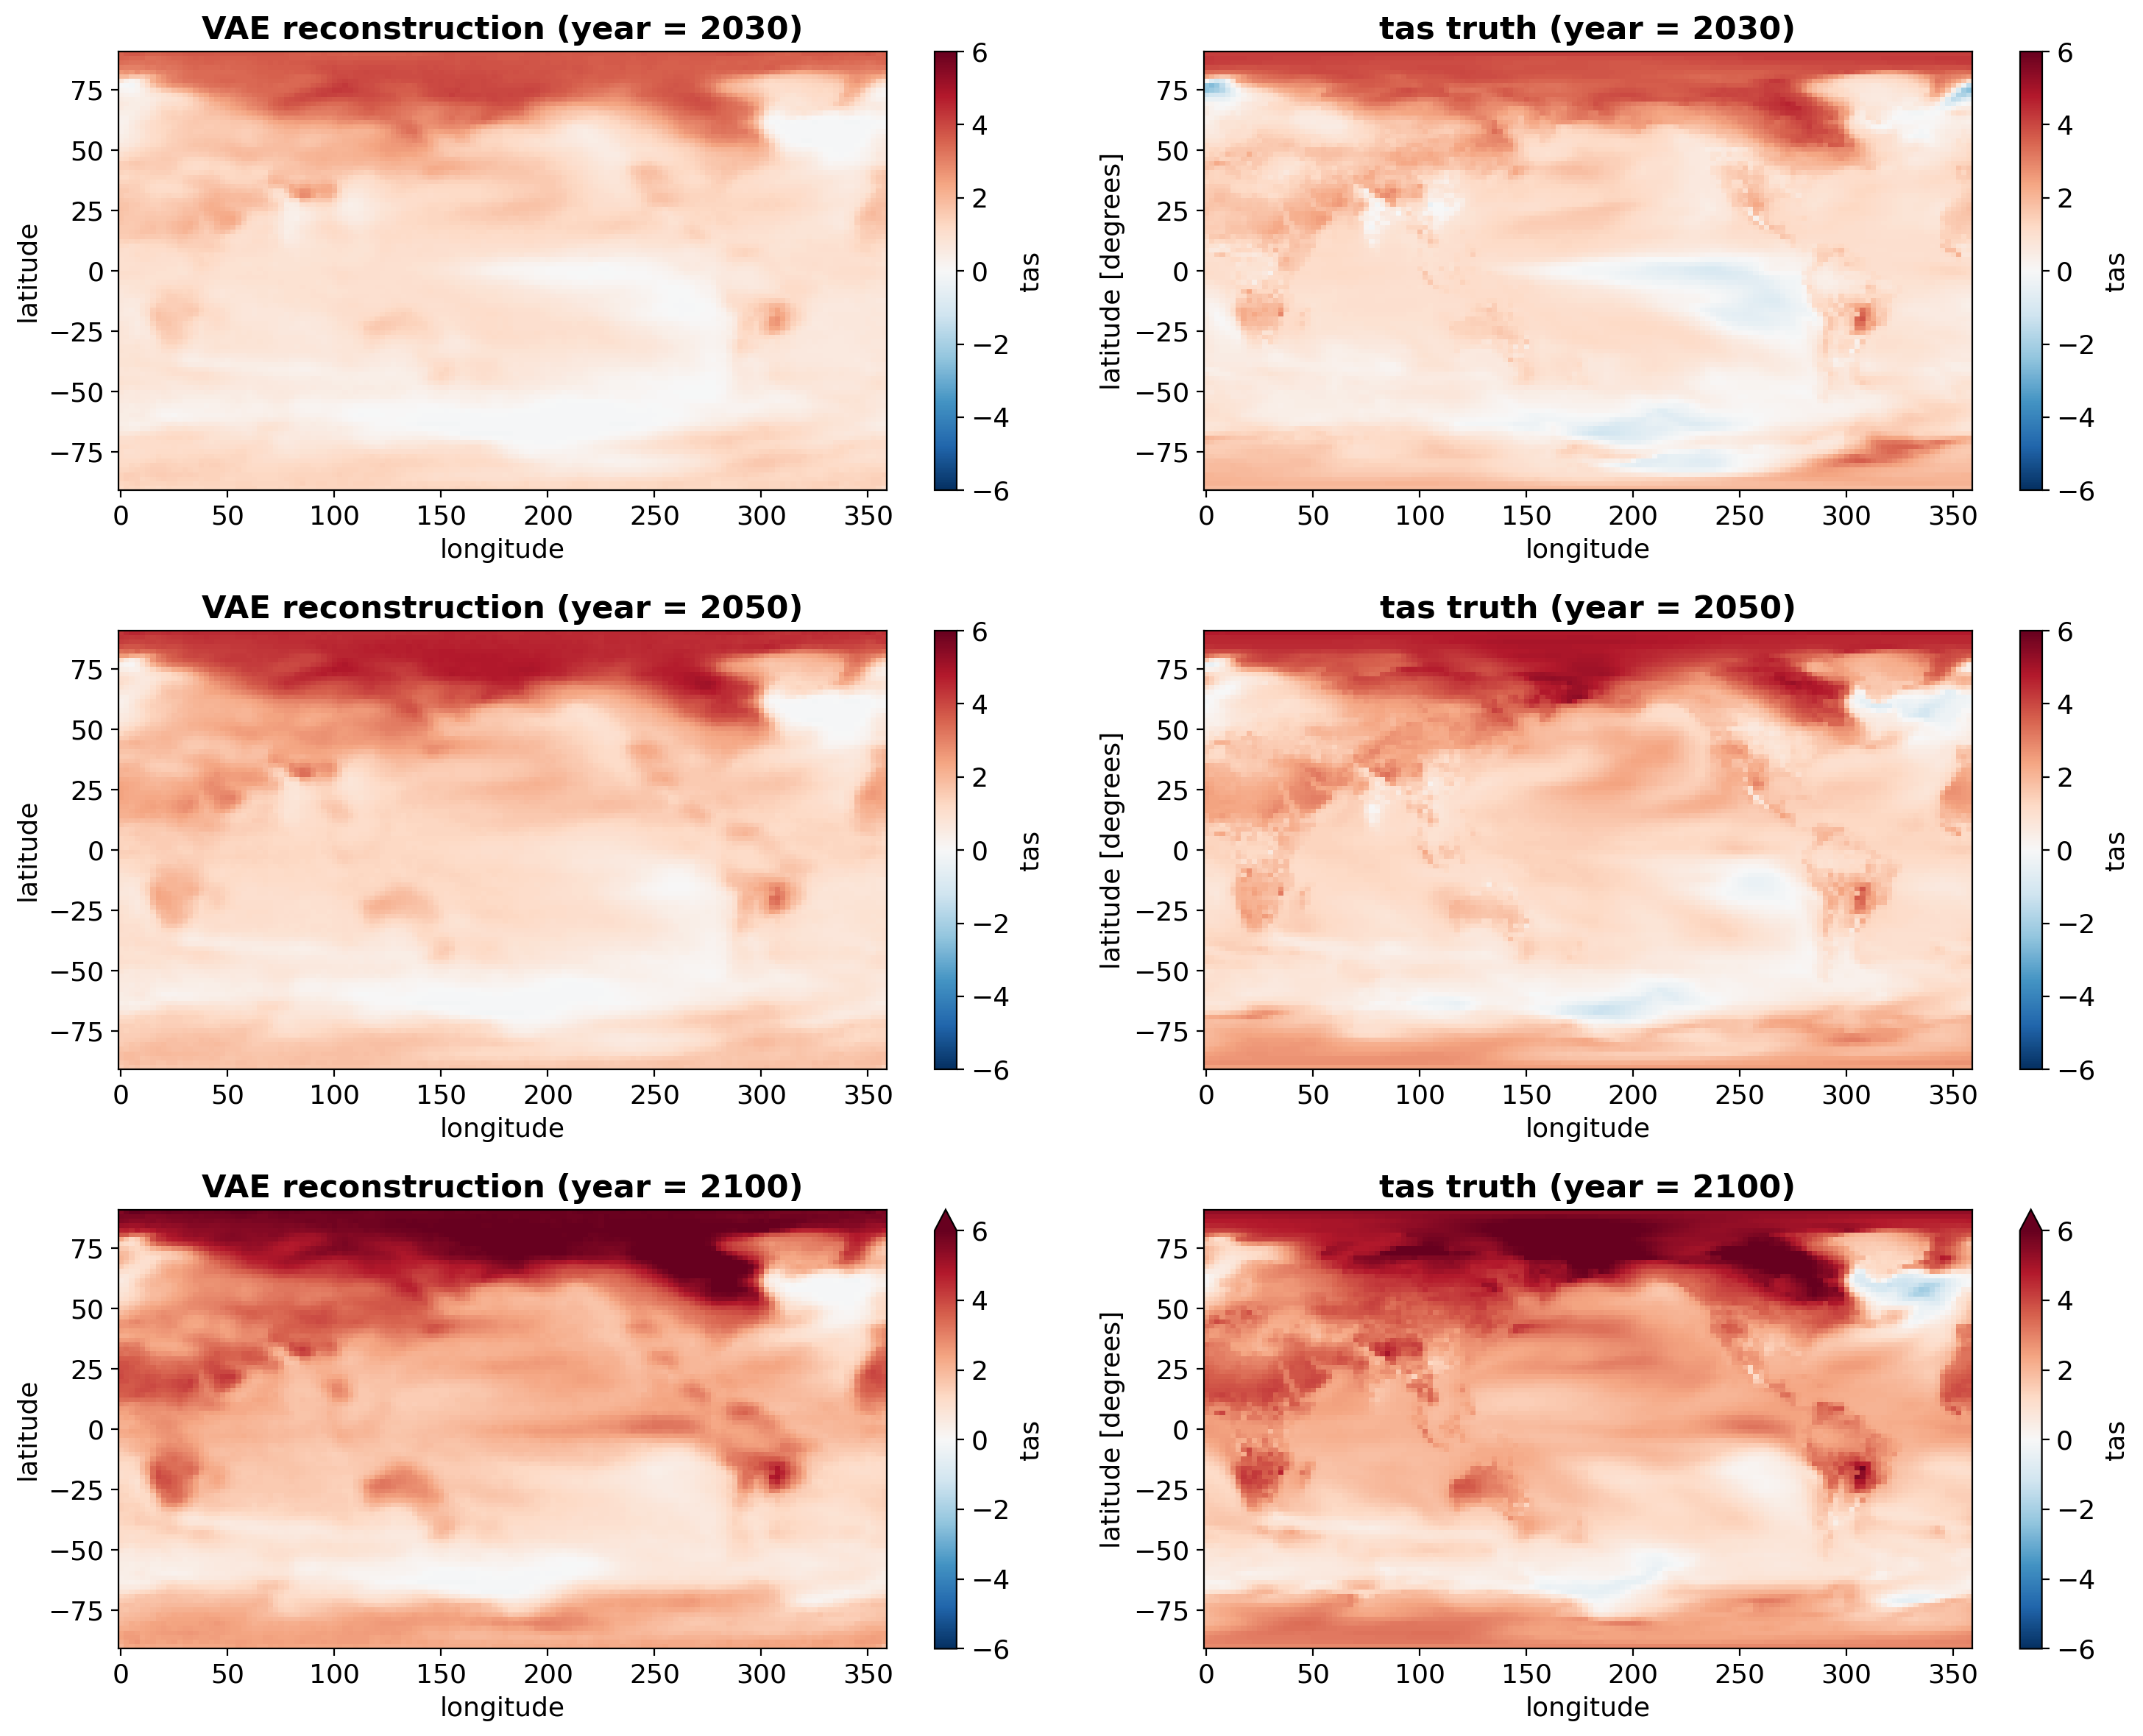

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

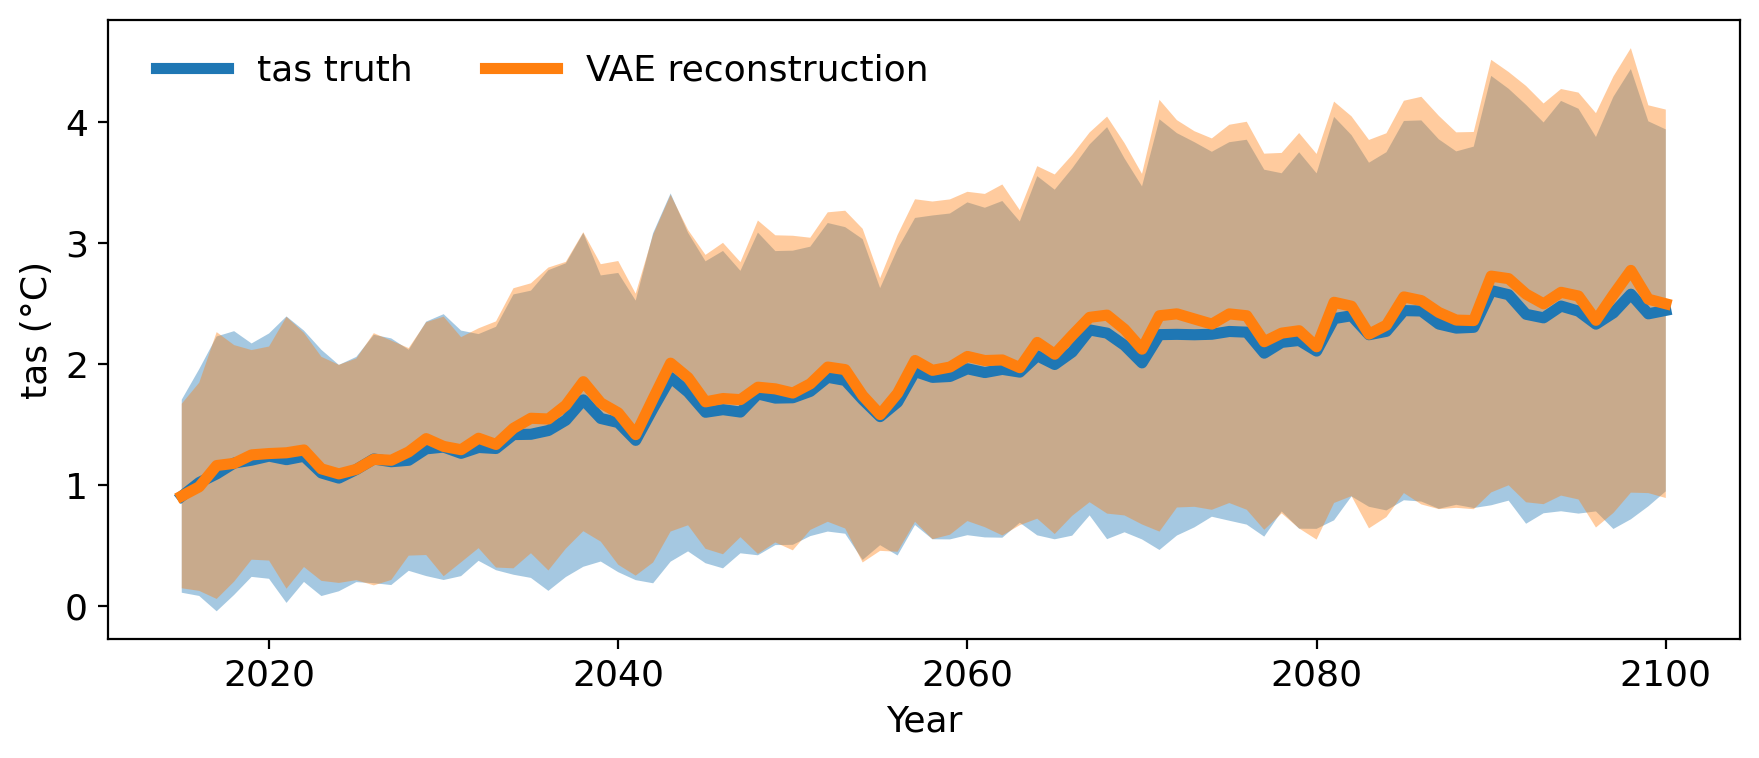

In [35]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(b.tas[35], a.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(b.tas[85], a.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(b.tas[30:41], a.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(b.tas[75:], a.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(br.tas[35:], a.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

In [31]:
y_test_pre.tas

<xarray.DataArray 'tas' (time: 86, latitude: 96, longitude: 144)>
array([[[0.7475311 , 0.8171456 , 0.8576724 , ..., 0.92045724,
         0.8372861 , 0.667757  ],
        [0.89606094, 0.93296605, 0.89999884, ..., 1.0036323 ,
         0.9845311 , 0.8886495 ],
        [0.98664176, 0.98436   , 0.93086153, ..., 0.97508454,
         1.0241796 , 0.96440446],
        ...,
        [2.5939755 , 2.5641227 , 2.6354241 , ..., 2.6990654 ,
         2.7439976 , 2.6874852 ],
        [2.6261003 , 2.6632051 , 2.681486  , ..., 2.8168023 ,
         2.7566497 , 2.7617433 ],
        [2.6672914 , 2.7665246 , 2.7981863 , ..., 2.8498414 ,
         2.821488  , 2.7509122 ]],

       [[0.7946986 , 0.8735934 , 0.9149443 , ..., 0.9962679 ,
         0.9123358 , 0.7221176 ],
        [0.96506584, 1.0097984 , 0.97149026, ..., 1.0946704 ,
         1.081336  , 0.967113  ],
        [1.0657246 , 1.069653  , 1.0070107 , ..., 1.0696405 ,
         1.1286205 , 1.0564916 ],
...
        [5.7740607 , 5.73167   , 5.810232  , ..., 5.840599  ,
         5.9774537 , 5.8540444 ],
        [5.919795  , 5.9528775 , 5.904338  , ..., 6.028068  ,
         5.963266  , 6.002038  ],
        [5.973299  , 6.1627054 , 6.184943  , ..., 5.9771576 ,
         6.0525103 , 5.9322643 ]],

       [[1.9237709 , 2.2785025 , 2.4380717 , ..., 2.540747  ,
         2.3336642 , 1.798166  ],
        [2.478116  , 2.7459383 , 2.6676652 , ..., 2.759236  ,
         2.7972634 , 2.3913758 ],
        [2.7339818 , 2.8724682 , 2.7056189 , ..., 2.5874274 ,
         2.7840075 , 2.5235105 ],
        ...,
        [5.8152604 , 5.7731075 , 5.8373938 , ..., 5.853331  ,
         5.9975834 , 5.8784227 ],
        [5.957764  , 5.9877315 , 5.9238143 , ..., 6.051788  ,
         5.989643  , 6.034583  ],
        [6.00783   , 6.1924405 , 6.2018027 , ..., 6.0135174 ,
         6.0906014 , 5.972851  ]]], dtype=float32)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

In [34]:
history

In [39]:
y_test_pre_mean = mean_pre
#y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean)))

TypeError: ignored

In [41]:
y_test_pre_mean

<xarray.DataArray 'tas' (time: 86)>
array([0.90947217, 0.985866  , 1.161376  , 1.1794609 , 1.2494898 ,
       1.2604034 , 1.2668711 , 1.2901654 , 1.1339332 , 1.0922973 ,
       1.1298872 , 1.2132356 , 1.2047414 , 1.2743323 , 1.3836998 ,
       1.3192153 , 1.2920204 , 1.3869599 , 1.3356128 , 1.4692979 ,
       1.5521256 , 1.5460488 , 1.6598327 , 1.8544759 , 1.6790446 ,
       1.596599  , 1.4168396 , 1.714677  , 2.0074306 , 1.8880465 ,
       1.6876519 , 1.715133  , 1.705914  , 1.8088701 , 1.7950555 ,
       1.7605704 , 1.8366473 , 1.9753364 , 1.9541869 , 1.7392135 ,
       1.582841  , 1.7580671 , 2.0294847 , 1.9480959 , 1.9753274 ,
       2.0631812 , 2.0290356 , 2.0339856 , 1.9703507 , 2.178982  ,
       2.0813155 , 2.2367663 , 2.386226  , 2.4047332 , 2.2875848 ,
       2.1232753 , 2.399641  , 2.4153104 , 2.372635  , 2.330331  ,
       2.4147382 , 2.3993356 , 2.184652  , 2.2557197 , 2.2755969 ,
       2.1430116 , 2.510664  , 2.4782152 , 2.2474213 , 2.3216166 ,
       2.5551355 , 2.5245638 , 2.4265676 , 2.3635728 , 2.3594317 ,
       2.7268875 , 2.706017  , 2.578097  , 2.4980114 , 2.5932302 ,
       2.5623972 , 2.3614867 , 2.5733745 , 2.774229  , 2.5362034 ,
       2.4983714 ], dtype=float32)
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [40]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.938908718720016
RMSE at 2100: 1.23270949305334
RMSE 2045-2055: 0.9728889272995648
RMSE 2090-2100: 1.3260072533589315
RMSE 2050-2100: 1.186663360468437
RMSE average last 20y: 1.234771547512401
